In [ ]:
import hmmlearn
from hmmlearn.hmm import GaussianHMM
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
import os
import seaborn as sns

In [2]:
sns.set_style('white')
os.chdir(r"C:\Users\czy\Desktop\课程\topics")
data=pd.read_csv('000001.SH.csv')
data=data.set_index('date')

In [3]:
#initialize
data_test=data[3000:]
data=data[:3000]
volume=data["volume"].values
close = data['close'].values
open_price=data['open'].values
high = data['high'].values
low = data['low'].values
swing=data['swing'].values

logreturn = (np.log(np.array(close[1:]))-np.log(np.array(close[:-1])))[4:]
logreturn5 = np.log(np.array(close[5:]))-np.log(np.array(close[:-5]))
logvolume=(np.log(np.array(volume[1:]))-np.log(np.array(volume[:-1])))[4:]
diffreturn = (np.array(high)-np.array(low))/np.array(close)       
diffreturn=diffreturn[5:]
swing=swing[5:]

In [4]:
#hmm learning
X = np.column_stack([logreturn,logreturn5])
hmm = GaussianHMM(n_components = 6, covariance_type='diag',n_iter = 5000).fit(X)
latent_states_sequence = hmm.predict(X)

C:\Software\anaconda\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Software\anaconda\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Software\anaconda\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Software\anaconda\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWar

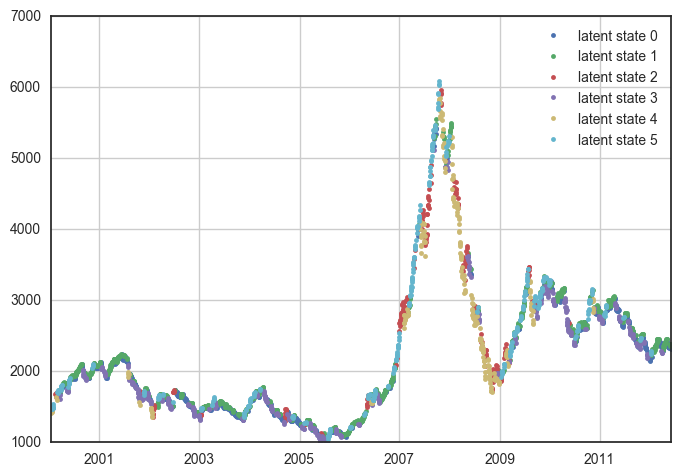

In [5]:
#plot market state sequence
datelist = pd.to_datetime(data['close'].index[5:])
closeidx = close[5:]
sns.set_style('white')
for i in range(hmm.n_components):
    state = (latent_states_sequence == i)
    plt.plot(datelist[state],closeidx[state],'.',label = 'latent state %d'%i,lw = 1)
    plt.legend()
    plt.grid(1)
    
plt.show()

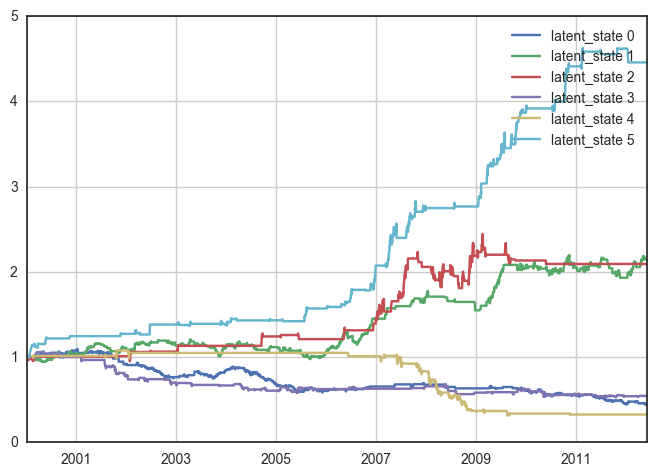

In [6]:
#test latent state
data = pd.DataFrame({'datelist':datelist,'logreturn':logreturn,'state':latent_states_sequence}).set_index('datelist')
for i in range(hmm.n_components):
    state = (latent_states_sequence == i)
    idx = np.append(0,state[:-1])
    data['state %d_return'%i] = data.logreturn.multiply(idx,axis = 0) 
    plt.plot(np.exp(data['state %d_return' %i].cumsum()),label = 'latent_state %d'%i) 
    plt.legend()
    plt.grid(1)
    
plt.show()

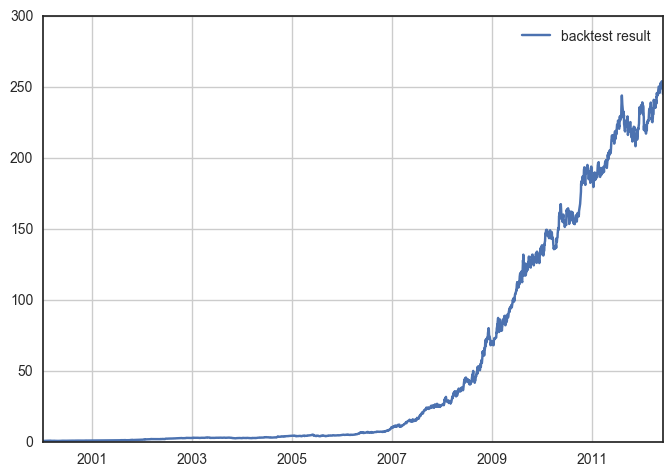

In [7]:
#construct strategy
buy=0;
sell=0;
for i in range(hmm.n_components):
    temp=np.exp(data['state %d_return' %i].cumsum())
    if temp[-1]>1.2 :
        buy=buy+(latent_states_sequence == i)
    if temp[-1]<1 :
        sell=sell+(latent_states_sequence == i)
buy = np.append(0,buy[:-1])
sell = np.append(0,sell[:-1])
data['backtest_return'] = data.logreturn.multiply(buy,axis = 0) \
                             - data.logreturn.multiply(sell,axis = 0)
plt.plot_date(datelist,np.exp(data['backtest_return'].cumsum()),'-',label='backtest result')
plt.legend()
plt.grid(1)
plt.show()

C:\Software\anaconda\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


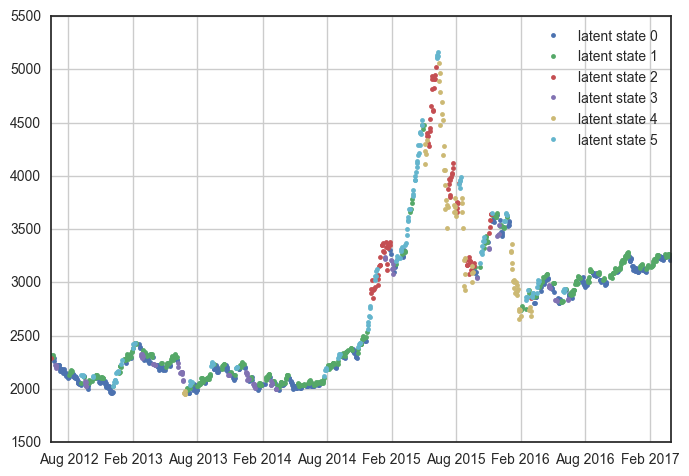

In [8]:
#test hmm
volume=data_test["volume"].values
close = data_test['close'].values
open_price=data_test['open'].values
high = data_test['high'].values
low = data_test['low'].values

logreturn = (np.log(np.array(close[1:]))-np.log(np.array(close[:-1])))[4:]
logreturn5 = np.log(np.array(close[5:]))-np.log(np.array(close[:-5]))
diffreturn = (np.array(high)-np.array(low))/np.array(close)       
diffreturn=diffreturn[5:]

X = np.column_stack([logreturn,logreturn5])
latent_states_sequence = hmm.predict(X)

datelist = pd.to_datetime(data_test['close'].index[5:])
closeidx = close[5:]

sns.set_style('white')
for i in range(hmm.n_components):
    state = (latent_states_sequence == i)
    plt.plot(datelist[state],closeidx[state],'.',label = 'latent state %d'%i,lw = 1)
    plt.legend()
    plt.grid(1)

plt.show()

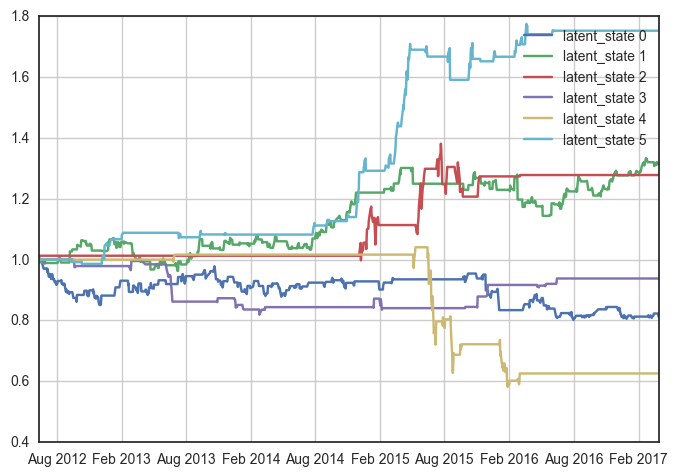

In [14]:
data = pd.DataFrame({'datelist':datelist,'logreturn':logreturn,'state':latent_states_sequence}).set_index('datelist')
for i in range(hmm.n_components):
    state = (latent_states_sequence == i)
    idx = np.append(0,state[:-1])
    data['state %d_return'%i] = data.logreturn.multiply(idx,axis = 0) 
    plt.plot(np.exp(data['state %d_return' %i].cumsum()),label = 'latent_state %d'%i) 
    plt.legend()
    plt.grid(1)

plt.show()

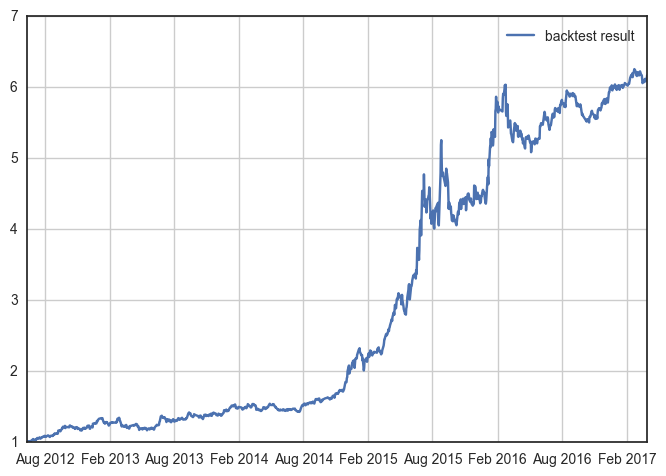

In [22]:
buy=0;
sell=0;
for i in range(hmm.n_components):
    temp=np.exp(data['state %d_return' %i].cumsum())
    if temp[-1]>1:
        buy=buy+(latent_states_sequence == i)
    if temp[-1]<1:
        sell=sell+(latent_states_sequence == i)
buy = np.append(0,buy[:-1])
sell = np.append(0,sell[:-1])
data['backtest_return'] = data.logreturn.multiply(buy,axis = 0) \
                             - data.logreturn.multiply(sell,axis = 0)
plt.plot_date(datelist,np.exp(data['backtest_return'].cumsum()),'-',label='backtest result')
plt.legend()
plt.grid(1)
plt.show()

In [23]:
backtest=np.exp(data['backtest_return'].cumsum())
retracement=0;
high=0;
for i in range(len(backtest)):
    if backtest[i]>high:
        high=backtest[i]
    temp=1-backtest[i]/high
    if temp>retracement:
        retracement=temp
print('retracement', retracement)

retracement 0.228026004104
